In [1]:
#basic operations
from typing import Union, Tuple, Optional

#math core
import numpy as np
from numpy.random import RandomState

import scipy
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt

In [2]:
class Operator:
    """
    A class containing static methods to generate convolution operators for various purposes.
    """
    @staticmethod
    def _convolve_operator(kernel: Union[list, np.ndarray], nt: int, offset: Optional[int] = None) -> np.ndarray:
        """
        Computes the discrete linear convolution operator for two one-dimensional sequences.

        Args:
            kernel (list or np.ndarray): First input array.
            nt (int): Length of the output array after convolution.
            offset (int, optional): Offset (default is half the length of `kernel`).

        Returns:
            np.ndarray: Convolution operator (nt, nt).

        Example:
            >>> kernel = [1, 2, 3]
            >>> nt = 5
            >>> result = convolve_operator(kernel, nt)
            >>> print(result)
            [[2. 3. 0. 0. 0.]
             [1. 2. 3. 0. 0.]
             [0. 1. 2. 3. 0.]
             [0. 0. 1. 2. 3.]
             [0. 0. 0. 1. 2.]]
        """
        try:
            # Calculate the offset if not provided
            offset = len(kernel) // 2 if offset is None else offset

            # Construct the first column and first row for Toeplitz matrix
            first_col, first_row = np.r_[kernel, np.zeros(nt + offset)], np.r_[kernel[0], np.zeros(nt - 1)]

            # Create the Toeplitz matrix and extract the relevant part
            operator = scipy.linalg.toeplitz(first_col, first_row)[offset: offset + nt]

            return operator
        except Exception as e:
            print(f"Error in _convolve_operator: {e}")
            return np.array([])

    @classmethod
    def first_derivative(cls, nt: int, mode: str = "forward") -> np.ndarray:
        """
        Generates a first-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: First-order derivative convolution operator (nt, nt).
            
        Example:
            >>> nt = 4
            >>> result = first_derivative(nt)
            >>> print(result)
            [[-1.  1.  0.  0.]
             [ 0. -1.  1.  0.]
             [ 0.  0. -1.  1.]
             [ 0.  0.  0. -1.]]
        
        """
        
        try:
            if mode == "forward":
                operator = cls._convolve_operator([-1, 1], nt, offset=1)
                operator[-1, :] = 0
            elif mode == "centered":
                operator = cls._convolve_operator([1, 0,-1], nt)
            return operator
        except Exception as e:
            print(f"Error in first_derivative: {e}")
            return np.array([])

    @classmethod
    def second_derivative(cls, nt: int) -> np.ndarray:
        """
        Generates a second-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Second-order derivative convolution operator (nt, nt).
        """
        try:
            operator = cls._convolve_operator([-1, 2, -1], nt, offset=2)
            operator[-2:, :] = 0
            return operator
        except Exception as e:
            print(f"Error in second_derivative: {e}")
            return np.array([])

    @classmethod
    def wavelet_operator(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Generates a convolution operator using the provided wavelet.

        Args:
            wavelet (list or np.ndarray): Wavelet array.
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Convolution operator using the provided wavelet (nt, nt).
        """
        try:
            operator = cls._convolve_operator(wavelet, nt)
            return operator
        except Exception as e:
            print(f"Error in wavelet_operator: {e}")
            return np.array([])

    @classmethod
    def acoustic(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Computes the acoustic operator (W*D, according to the convolutional model of seismic trace) 
        for a given wavelet and length of the output array.

        Args:
            wavelet (list or np.ndarray): One-dimensional array representing the wavelet.
            nt (int): Length of the output array.

        Returns:
            np.ndarray: Acoustic operator (nt, nt).

        Example:
            >>> wavelet = [1, -1, 2]
            >>> nt = 4
            >>> result = acoustic_operator(wavelet, nt)
            >>> print(result)
            [[-1.  2. -1.  0.]
             [ 2. -3.  2. -1.]
             [ 0.  2. -3.  2.]
             [ 0.  0.  2. -3.]]
        """
        try:
            return cls.wavelet_operator(wavelet, nt) @ cls.first_derivative(nt)
        except Exception as e:
            print(f"Error in acoustic: {e}")
            return np.array([])
    

    @classmethod
    def akirichards(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def fatti(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def ps(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def zoeppritz(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def tikhonov(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def avo(cls, input_data) -> np.ndarray:
        pass

def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [3]:
class Wavelet:
    def __init__(self):
        pass
    
    def get_rpp(self, impedances: np.ndarray) -> np.ndarray:
        """
        Считает коэффициенты отражения из трассы импедансов

        Parameters:
        - impedances (np.ndarray): 1-d array импеданса.

        Returns:
        - np.ndarray: Array коэф. отражения.
        """

        # Check if the input is a NumPy array
        if not isinstance(impedances, np.ndarray):
            raise TypeError("Input must be a NumPy array")

        # Check if the input array is 1-dimensional
        if impedances.ndim == 1:
            # Pad the array at the edges to ensure calculation for first and last elements
            impedances = np.pad(impedances, pad_width=(1,), mode="edge")

            # Calculate reflection coefficients
            rpp = np.diff(impedances) / (impedances[:-1] + impedances[1:])
        else:
            raise ValueError("Input array must be 1-dimensional")

        return rpp
    

    def get_rpp_matrix(self, signal: np.ndarray, wavelet_length: int) -> np.ndarray:
        """
        Parameters:
        - signal (np.ndarray): сигнал.
        - wavelet_length (int): длина вейвлета.

        Returns:
        - np.ndarray: матрица коэф .отражения.

        Raises:
        - ValueError: если длина не целое положительное.
        """

        if not isinstance(wavelet_length, int) or wavelet_length <= 0:
            raise ValueError("Wavelet length must be a positive integer.")

        N = len(signal)
        M = wavelet_length

        W_matrix = np.zeros((N, M))

        trace_merged = np.hstack((signal, np.zeros(N)))

        for i in range(N):
            if i <= wavelet_length // 2:
                W_matrix[i, :wavelet_length // 2 + i] = np.flip(trace_merged[:wavelet_length // 2 + i])
            else:
                W_matrix[i, :] = np.flip(trace_merged[i - wavelet_length // 2 : wavelet_length // 2 + i])



        return W_matrix

    def wavelet_extraction(self,
                           impedance_trace: np.ndarray, 
                           seismic_trace: np.ndarray, 
                           desired_length=100, 
                           filtered=False, 
                           dt=1) -> np.ndarray:
        """
        Извлекает импульс из трассы импедансов и сейсмической трассы.

        Parameters:
        - impedance_trace (np.ndarray): трасса импедансов.
        - seismic_trace (np.ndarray): сейсмотрасса.
        - desired_length (int): желаемая длина вейвлета (опц.).
        - filtered (bool): сгливание.
        - dt (float): шаг дискретизации.

        Returns:
        - np.ndarray: извлеченный импульс.

        Raises:
        - ValueError: If input dimensions are incompatible or if inversion fails.
        """

        assert impedance_trace.shape == seismic_trace.shape, "Impedance and seismic traces must have the same dimensions."
        assert desired_length <= len(impedance_trace), "Desired length cannot be greater than the length of impedance_trace."
        rpp = self.get_rpp(impedance_trace)
        rpp_matrix = self.get_rpp_matrix(rpp[:-1], desired_length)


        try:
            wavelet = np.linalg.pinv(rpp_matrix.T @ rpp_matrix) @ rpp_matrix.T @ seismic_trace
        except np.linalg.LinAlgError:
            raise ValueError("Unable to compute the inversion matrix. Check if the matrix is invertible.")

        if filtered:
            wavelet *= signal.tukey(desired_length, 0.001)
            wavelet = scipy.ndimage.gaussian_filter(wavelet, 1.001)


        # return wavelet
        return np.pad(-wavelet, (2, 0), mode='constant', constant_values = 0)[:-2] #косталь, возможно где-то в матрице сдвиг есть

C:\Users\Владислав\AppData\Local\Temp\ipykernel_10484\3722346008.py:9: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = signal.ricker(points, a)


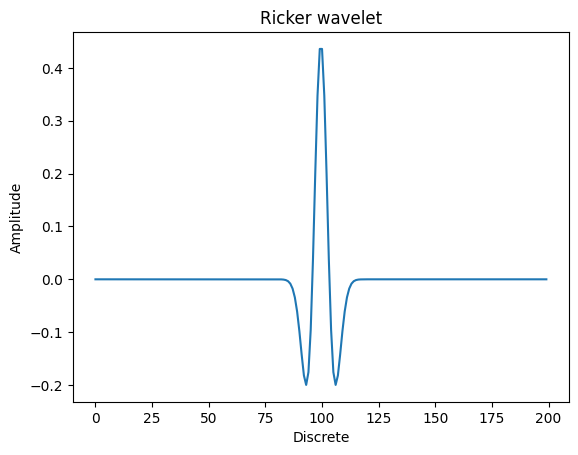

In [4]:
# Define parameters
points = 200  # Number of points in the wavelet
dt = 0.002  # Time step
bfreq = 1. / dt  # Base frequency calculated based on the time step
mean_freq = 30  # Mean frequency of the Ricker wavelet
a = bfreq / (np.sqrt(2.0) * np.pi * mean_freq)  # Parameter used in the Ricker wavelet formula

# Generate Ricker wavelet using scipy's signal.ricker
wavelet = signal.ricker(points, a)

# plt.style.use("cyberpunk")
plt.plot(wavelet)
plt.title("Ricker wavelet")
plt.xlabel("Discrete")
plt.ylabel("Amplitude")
plt.show()

In [5]:
rs = RandomState(42)

nt = 500 #the length of traces

impedance = np.zeros(nt)

thickness = 80
global_variations_amplitude = 700
local_variations_amplitude = 350
trend_slope = 4
trend_intercept = 5000

low_frequency_trend = trend_slope*np.arange(nt) + trend_intercept

for i in range(thickness, nt):
    if not i%thickness:
        impedance[i-thickness: i] = rs.randint(-global_variations_amplitude, global_variations_amplitude) 
        
impedance += rs.normal(loc = 0.00, scale = local_variations_amplitude, size = (nt))
impedance += low_frequency_trend
 
impedance_smoothed = scipy.ndimage.gaussian_filter(impedance, 2)
low_frequency_model = butter_lowpass_filter(impedance, cutoff = 8, fs = nt, order = 2)

In [6]:
seismic_trace = 0.5*Operator.acoustic(wavelet, nt)@np.log(impedance_smoothed)

power = np.abs(np.fft.rfft(seismic_trace)) 
frequency = np.fft.rfftfreq(len(seismic_trace), 0.002) 

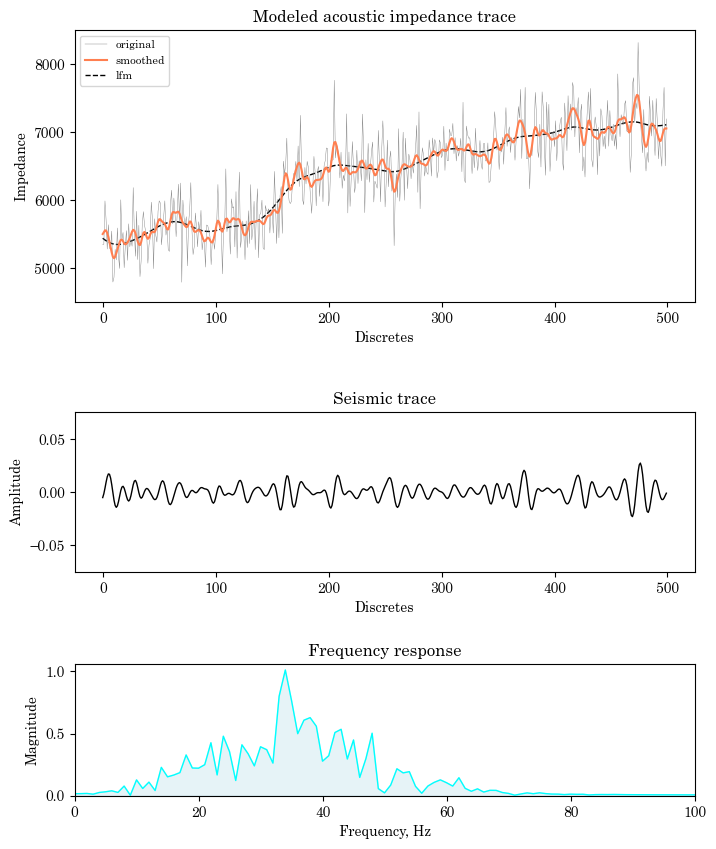

In [7]:
plt.rcParams["font.family"] = "century"

plt.figure(figsize = (8, 12))

plt.subplot(3, 1, 1)
plt.plot(impedance, "grey", lw = 0.3, label = "original")
plt.plot(impedance_smoothed, c = "coral", lw = 1.5, zorder = 2, label = "smoothed")
plt.plot(low_frequency_model, c = "black", ls = "--", lw = 1, zorder = 1, label = "lfm")
plt.ylim([4500, 8500])
plt.yticks(np.arange(5e3, 8.1e3, 1e3))
plt.title("Modeled acoustic impedance trace")
plt.ylabel("Impedance")
plt.xlabel("Discretes")
plt.legend(fontsize = 8)

plt.subplot(5, 1, 3)
plt.plot(seismic_trace, c = "black", lw = 1)
plt.ylim([-0.075, 0.075])
# plt.yticks(np.arange(4e3, 8.1e3, 1e3))
plt.title("Seismic trace")
plt.ylabel("Amplitude")
plt.xlabel("Discretes")

plt.subplot(6, 1, 5)
plt.title("Frequency response")
plt.plot(frequency, np.abs(power), c = "aqua", lw = 1)
plt.xlim([0, 100])
plt.ylim([0, None])
plt.xlabel("Frequency, Hz")
plt.ylabel("Magnitude")
plt.fill_between(frequency, np.abs(power),
                color='lightblue', alpha=0.3)

plt.show()

In [8]:
wave = Wavelet() 

In [9]:
#Извлечение вейвлета
wavelet_new = wave.wavelet_extraction(impedance_trace = impedance_smoothed, 
                                      seismic_trace = seismic_trace, 
                                      desired_length = 200, 
                                      filtered = False)

In [12]:
# pip install mplcyberpunk
# import mplcyberpunk

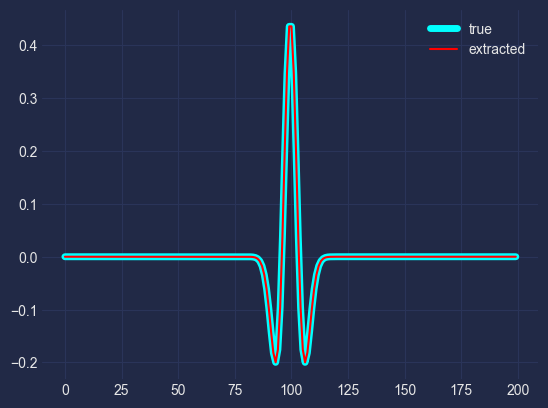

In [14]:
# plt.style.use("cyberpunk")
plt.plot(wavelet, lw = 5, c = "aqua",  label = "true")
plt.plot(wavelet_new, c = "red", label = "extracted")
plt.legend()